<a href="https://colab.research.google.com/github/elsrdelanoche/Quiroscopio_SVM/blob/main/pruebas_y_comparativas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# === 0) Setup ===
!pip -q install numpy pandas scipy scikit-learn tqdm tslearn umap-learn matplotlib joblib pyyaml

from pathlib import Path
import os, re, json, yaml, math, gc, random
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import StratifiedKFold, train_test_split, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
import umap

from tslearn.metrics import cdist_dtw

SEED = 42
random.seed(SEED); np.random.seed(SEED)

# Rutas
DATA_ROOT = "/content/drive/MyDrive/Dataset"
OUT_DIR   = "/content/drive/MyDrive/Quiroscopio_DatasetBuild_v2"
os.makedirs(OUT_DIR, exist_ok=True)

GESTURE_DIRS = ["gestosS1","gestosS2","gestosS3"]
GESTURES = ["gesto-zoom-in","gesto-zoom-out","gesto-grab","gesto-drop","gesto-slide-izquierda","gesto-slide-derecha"]
SENSORS = list(range(5))
CHANNELS = ["ax","ay","az","w","i","j","k"]
TIME_SAMPLES = 64

# Núcleo v2 (parámetros)
REF_PER_SESSION = 3      # cuántas semillas (primeros gestos) por sesión
CORE_KEEP_FRAC  = 0.80   # 80% para dataset, 20% validación-holdout (sobre el "máximo común" por clase)

print("OK setup")

OK setup


In [ ]:
# === 1) Carga + CC ===
from google.colab import drive
drive.mount('/content/gdrive_alt', force_remount=True)
DATA_ROOT = "/content/gdrive_alt/MyDrive/Dataset"
OUT_DIR   = "/content/gdrive_alt/MyDrive/Quiroscopio_DatasetBuild_v2"


def load_one_csv(path: Path):
    df = pd.read_csv(path)
    req = {"sample","sensor","ax","ay","az","w","i","j","k"}
    if not req.issubset(df.columns):
        raise ValueError(f"Columnas faltantes en {path.name}")
    return df

def pivot_tensor(df):
    # Validaciones
    sensors_present = sorted(df["sensor"].unique().tolist())
    if sensors_present != SENSORS:
        return None, False, f"sensores {sensors_present} != {SENSORS}"
    cnt = df.groupby("sensor")["sample"].nunique()
    if not all(cnt == TIME_SAMPLES):
        return None, False, "samples incompletos"
    # Tensor [T,S,C]
    ten = np.zeros((TIME_SAMPLES, len(SENSORS), len(CHANNELS)), dtype=np.float32)
    for s in SENSORS:
        sdf = df[df.sensor==s].sort_values("sample")
        ten[:,s,0:3] = sdf[["ax","ay","az"]].values
        ten[:,s,3:7] = sdf[["w","i","j","k"]].values
    return ten, True, ""

records = []
bad = []
for sess in tqdm(GESTURE_DIRS, desc="Sesiones"):
    for gest in GESTURES:
        folder = Path(DATA_ROOT)/sess/gest
        if not folder.exists():
            print("[WARN] No existe", folder);
            continue
        # "Primeros gestos" se deducen por orden lexicográfico del nombre
        for csv in sorted(folder.glob("*_plot.csv")):
            try:
                df = load_one_csv(csv)
                ten, ok, msg = pivot_tensor(df)
                if not ok:
                    bad.append((str(csv), msg)); continue
                records.append({"session":sess,"gesture":gest,"file":str(csv),"tensor":ten})
            except Exception as e:
                bad.append((str(csv), f"error: {e}"))

print(f"Cargados OK: {len(records)} | Rechazados: {len(bad)}")
if bad:
    print("Ejemplos rechazados:", bad[:5])
meta = pd.DataFrame([{"session":r["session"],"gesture":r["gesture"],"file":r["file"]} for r in records])


Mounted at /content/gdrive_alt


Sesiones:   0%|          | 0/3 [00:00<?, ?it/s]

Cargados OK: 3354 | Rechazados: 0


In [ ]:
!tree

/bin/bash: line 1: tree: command not found


In [ ]:
# === 2) Normalización ===
from joblib import dump, load
from pathlib import Path
import os

def normalize_quaternions(Q):
    norm = np.linalg.norm(Q, axis=-1, keepdims=True) + 1e-9
    Qn = Q / norm
    flip = (Qn[...,0] < 0)[...,None]
    Qn = Qn * np.where(flip, -1.0, 1.0)
    return Qn

# Renorm + hemisferio para todos
for r in records:
    Q = r["tensor"][...,3:7]
    r["tensor"][...,3:7] = normalize_quaternions(Q)

# Ajustamos RobustScaler solo con acelerómetros (sobre todo el conjunto; si quieres, usa subset)
Xacc = np.concatenate([r["tensor"][..., :3].reshape(-1,3) for r in records], axis=0)
robust_scaler = RobustScaler(quantile_range=(25,75))
robust_scaler.fit(Xacc)

# Aplicar
for r in records:
    acc = r["tensor"][..., :3].reshape(-1,3)
    r["tensor"][..., :3] = robust_scaler.transform(acc).reshape(TIME_SAMPLES, len(SENSORS), 3)

Path(OUT_DIR).mkdir(parents=True, exist_ok=True)

dump(robust_scaler, Path(OUT_DIR,"robust_scaler_acc.joblib"))
print("Normalización completada")


Normalización completada


In [ ]:
# === 3) Serie 1D y Núcleo v2 ===
def series_ref(tensor):
    acc = tensor[...,:3]
    q   = tensor[...,3:7]
    acc_mag_t = np.sqrt((acc**2).sum(-1)).mean(axis=1)  # [T]
    dq = np.diff(q, axis=0)
    dq_norm_t = np.linalg.norm(dq, axis=-1).mean(axis=1)
    dq_pad = np.concatenate([[0.0], dq_norm_t])
    s = acc_mag_t + 0.5*dq_pad
    z = (s - s.mean())/(s.std()+1e-6)
    return z.astype(np.float32)

# Construir serie 1D
for r in records:
    r["series1d"] = series_ref(r["tensor"])

# Construir semillas: por cada gesto y sesión, tomar REF_PER_SESSION primeros archivos
from collections import defaultdict
idx_by_gesture = defaultdict(list)
idx_by_gesture_sess = defaultdict(lambda: defaultdict(list))

for i, r in enumerate(records):
    idx_by_gesture[r["gesture"]].append(i)
    idx_by_gesture_sess[r["gesture"]][r["session"]].append(i)

# Orden por nombre de archivo para que "primeros" sea consistente
for g in GESTURES:
    for s in GESTURE_DIRS:
        idxs = idx_by_gesture_sess[g][s]
        idxs_sorted = sorted(idxs, key=lambda i: records[i]["file"])
        idx_by_gesture_sess[g][s] = idxs_sorted

# Semillas
seed_idx_by_g = {}
for g in GESTURES:
    seeds = []
    for s in GESTURE_DIRS:
        cand = idx_by_gesture_sess[g][s][:REF_PER_SESSION]
        seeds.extend(cand)
    seed_idx_by_g[g] = seeds

# Puntuar: distancia mínima DTW a cualquiera de las semillas de su mismo gesto
def dtw_min_to_seeds(indices, seeds):
    S_all = [records[i]["series1d"] for i in indices]
    S_seed = [records[i]["series1d"] for i in seeds] if seeds else []
    if not S_seed:
        # si no hay semillas, todo queda con +inf (se conservarán al final si es necesario)
        return np.full(len(indices), np.inf, dtype=np.float32)
    # matriz dist: muestras x semillas
    D = cdist_dtw(S_all, S_seed)  # [n, m]
    return np.min(D, axis=1)

scores_by_idx = {}
for g in tqdm(GESTURES, desc="Scoring vs seeds"):
    idxs = idx_by_gesture[g]
    seeds = seed_idx_by_g[g]
    if len(idxs)==0:
        continue
    scores = dtw_min_to_seeds(idxs, seeds)
    for ii, sc in zip(idxs, scores):
        scores_by_idx[ii] = sc

# Orden por gesto (menor distancia = más similar)
ordered_by_gesture = {}
for g in GESTURES:
    idxs = idx_by_gesture[g]
    idxs_sorted = sorted(idxs, key=lambda i: scores_by_idx.get(i, np.inf))
    ordered_by_gesture[g] = idxs_sorted

# "Máximo común" por clase
n_by_g = {g: len(idx_by_gesture[g]) for g in GESTURES}
common = min(n_by_g.values()) if n_by_g else 0
core_per_class = int(math.floor(common * CORE_KEEP_FRAC))
val_per_class  = common - core_per_class

print("n_by_g:", n_by_g)
print(f"common={common}, core/class={core_per_class}, val/class={val_per_class}")

# Selección final por clase: tomar top 'common' según cercanía a semillas
core_pool_idx, val_holdout_idx = [], []
for g in GESTURES:
    ordered = ordered_by_gesture[g][:common]   # top-common
    # split 80/20
    k_core = core_per_class
    core_pool_idx.extend(ordered[:k_core])
    val_holdout_idx.extend(ordered[k_core:common])

core_pool_idx = np.array(core_pool_idx, dtype=int)
val_holdout_idx = np.array(val_holdout_idx, dtype=int)

np.save(Path(OUT_DIR,"core_pool_idx.npy"), core_pool_idx)
np.save(Path(OUT_DIR,"val_holdout_idx.npy"), val_holdout_idx)

print("Resumen núcleo v2 (por clase):")
for g in GESTURES:
    c = sum(records[i]["gesture"]==g for i in core_pool_idx)
    v = sum(records[i]["gesture"]==g for i in val_holdout_idx)
    print(f"  {g}: core={c} | val={v}")
print("Totales:", len(core_pool_idx), len(val_holdout_idx))


Scoring vs seeds:   0%|          | 0/6 [00:00<?, ?it/s]

n_by_g: {'gesto-zoom-in': 505, 'gesto-zoom-out': 512, 'gesto-grab': 434, 'gesto-drop': 438, 'gesto-slide-izquierda': 674, 'gesto-slide-derecha': 791}
common=434, core/class=347, val/class=87
Resumen núcleo v2 (por clase):
  gesto-zoom-in: core=347 | val=87
  gesto-zoom-out: core=347 | val=87
  gesto-grab: core=347 | val=87
  gesto-drop: core=347 | val=87
  gesto-slide-izquierda: core=347 | val=87
  gesto-slide-derecha: core=347 | val=87
Totales: 2082 522


In [ ]:
# === 4) Feature engineering ===
from scipy.signal import resample
from scipy.fft import rfft

def feats_time_summary(tensor):
    from scipy.stats import skew, kurtosis
    T,S,C = tensor.shape
    out=[]
    for s in range(S):
        X = tensor[:,s,:]
        mean_ = X.mean(0)
        std_  = X.std(0)+1e-9
        min_  = X.min(0); max_ = X.max(0)
        p25 = np.percentile(X,25,axis=0); p50=np.percentile(X,50,axis=0); p75=np.percentile(X,75,axis=0)
        energy = (X**2).sum(0)/T
        rms = np.sqrt((X**2).mean(0))
        from numpy import arange
        t = arange(T)[:,None]
        beta = ((t-t.mean())*(X-X.mean(0))).sum(0) / (((t-t.mean())**2).sum()+1e-9)
        sk = skew(X, axis=0, bias=False, nan_policy='omit')
        ku = kurtosis(X, axis=0, bias=False, nan_policy='omit')
        out.append(np.concatenate([mean_,std_,min_,max_,p25,p50,p75,energy,rms,beta,sk,ku]))
    return np.concatenate(out).astype(np.float32)

def feats_time_extended(tensor, downsample_to=64):
    T,S,C = tensor.shape
    if downsample_to!=T:
        ten = np.zeros((downsample_to,S,C), dtype=np.float32)
        for s in range(S):
            for c in range(C):
                ten[:,s,c] = resample(tensor[:,s,c], num=downsample_to)
        tensor = ten
    return tensor.reshape(-1).astype(np.float32)

def feats_time_fft(tensor, n_bins=16):
    T,S,C = tensor.shape
    out=[]
    for s in range(S):
        for c in range(C):
            mag = np.abs(rfft(tensor[:,s,c]))
            out.append(mag[:n_bins])
    return np.concatenate(out).astype(np.float32)

def build_features(indices, variant="time-summary", **kwargs):
    X, y, rows = [], [], []
    for i in tqdm(indices, desc=f"Features[{variant}]"):
        ten = records[i]["tensor"]
        if variant=="time-summary":
            f = feats_time_summary(ten)
        elif variant=="time-extended":
            f = feats_time_extended(ten, **kwargs)
        elif variant=="time+fft":
            f = feats_time_fft(ten, **kwargs)
        else:
            raise ValueError("variant?")
        X.append(f); y.append(records[i]["gesture"])
        rows.append({"idx":int(i),"gesture":records[i]["gesture"],"session":records[i]["session"],"file":records[i]["file"]})
    return np.stack(X), np.array(y), pd.DataFrame(rows)

# Construir y guardar
variants = {
    "time-summary": {},
    "time-extended": {"downsample_to":64},
    "time+fft": {"n_bins":16}
}

for variant, kw in variants.items():
    for split_name, idxs in [("core_pool", core_pool_idx), ("val_holdout", val_holdout_idx)]:
        X, y, m = build_features(idxs, variant=variant, **kw)
        base = Path(OUT_DIR, f"{variant}_{split_name}")
        np.save(base.with_suffix(".X.npy"), X)
        np.save(base.with_suffix(".y.npy"), y)
        m.to_parquet(base.with_suffix(".meta.parquet"))
    print("OK", variant)

# === 4b) Features para KNN ===
# Usaremos "time-summary" como base para KNN (suele ir muy bien), estandarizamos y opcional PCA
Xs = np.load(Path(OUT_DIR,"time-summary_core_pool.X.npy"))
ys = np.load(Path(OUT_DIR,"time-summary_core_pool.y.npy"))
Xs_val = np.load(Path(OUT_DIR,"time-summary_val_holdout.X.npy"))
ys_val = np.load(Path(OUT_DIR,"time-summary_val_holdout.y.npy"))

scaler_knn = StandardScaler()
Xs_std = scaler_knn.fit_transform(Xs)
Xs_val_std = scaler_knn.transform(Xs_val)

# (Opcional) PCA para compactar y quitar ruido
USE_PCA = True
PCA_N = min(64, Xs_std.shape[1])
if USE_PCA:
    pca = PCA(n_components=PCA_N, random_state=SEED)
    Xs_knn = pca.fit_transform(Xs_std)
    Xs_val_knn = pca.transform(Xs_val_std)
else:
    pca = None
    Xs_knn = Xs_std; Xs_val_knn = Xs_val_std

from joblib import dump
dump(scaler_knn, Path(OUT_DIR,"knn_scaler.joblib"))
if pca: dump(pca, Path(OUT_DIR,"knn_pca.joblib"))

print("KNN-ready shapes:", Xs_knn.shape, Xs_val_knn.shape)


Features[time-summary]:   0%|          | 0/2082 [00:00<?, ?it/s]

Features[time-summary]:   0%|          | 0/522 [00:00<?, ?it/s]

OK time-summary


Features[time-extended]:   0%|          | 0/2082 [00:00<?, ?it/s]

Features[time-extended]:   0%|          | 0/522 [00:00<?, ?it/s]

OK time-extended


Features[time+fft]:   0%|          | 0/2082 [00:00<?, ?it/s]

Features[time+fft]:   0%|          | 0/522 [00:00<?, ?it/s]

OK time+fft
KNN-ready shapes: (2082, 64) (522, 64)


/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


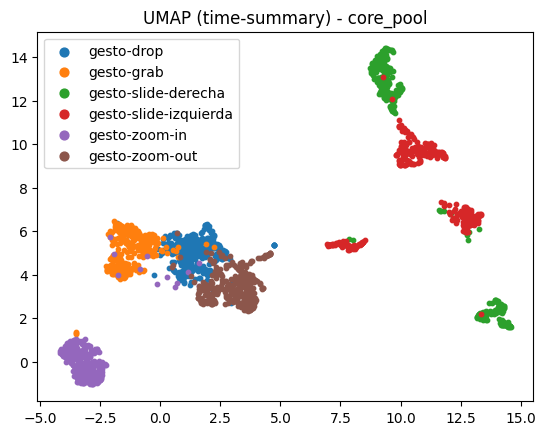

/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


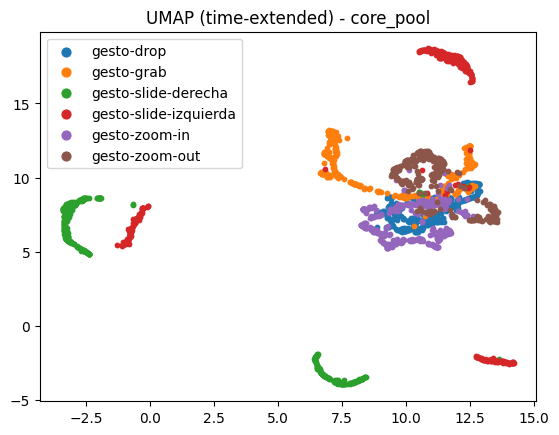

/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


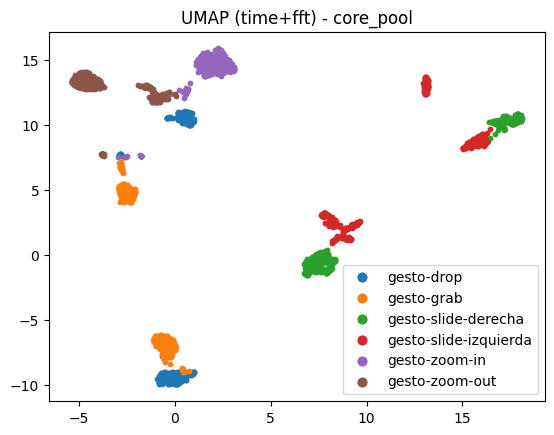

/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


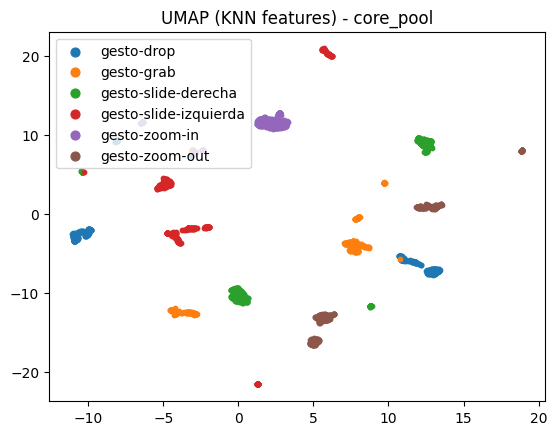

In [ ]:
# === 5) Embeddings 2D ===
def umap_2d(X, y, title):
    reducer = umap.UMAP(n_components=2, random_state=SEED)
    Z = reducer.fit_transform(X)
    plt.figure()
    for g in np.unique(y):
        m = (y==g)
        plt.scatter(Z[m,0], Z[m,1], s=10, label=g)
    plt.legend(markerscale=2)
    plt.title(title)
    plt.show()

# Core-pool (dataset)
for variant in ["time-summary","time-extended","time+fft"]:
    X = np.load(Path(OUT_DIR,f"{variant}_core_pool.X.npy"))
    y = np.load(Path(OUT_DIR,f"{variant}_core_pool.y.npy"))
    umap_2d(X, y, f"UMAP ({variant}) - core_pool")

# KNN (sobre features estandarizados y PCA opcional)
umap_2d(Xs_knn, ys, "UMAP (KNN features) - core_pool")


In [ ]:
# === 6) KNN baseline con CV ===
# Sobre Xs_knn / ys ya construidos (time-summary std + pca opcional)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)
accs, f1s = [], []
for tr, va in tqdm(cv.split(Xs_knn, ys), total=cv.get_n_splits(), desc="CV"):
    clf = KNeighborsClassifier(n_neighbors=5, metric="euclidean", weights="distance")
    clf.fit(Xs_knn[tr], ys[tr])
    pred = clf.predict(Xs_knn[va])
    accs.append(accuracy_score(ys[va], pred))
    f1s.append(f1_score(ys[va], pred, average="macro"))
print("KNN CV - mean acc:", np.mean(accs), "±", np.std(accs))
print("KNN CV - mean macro-F1:", np.mean(f1s), "±", np.std(f1s))

# Chequeo externo en val_holdout
clf = KNeighborsClassifier(n_neighbors=5, metric="euclidean", weights="distance")
clf.fit(Xs_knn, ys)
pred_val = clf.predict(Xs_val_knn)
print("\n[Holdout 20%] acc:", accuracy_score(ys_val, pred_val),
      "macro-F1:", f1_score(ys_val, pred_val, average="macro"))
print(classification_report(ys_val, pred_val))


CV:   0%|          | 0/5 [00:00<?, ?it/s]

KNN CV - mean acc: 0.9975984596937835 ± 0.002147490751297987
KNN CV - mean macro-F1: 0.9975944697347184 ± 0.0021493345008817507

[Holdout 20%] acc: 0.9980842911877394 macro-F1: 0.9980842279108176
                       precision    recall  f1-score   support

           gesto-drop       1.00      1.00      1.00        87
           gesto-grab       1.00      1.00      1.00        87
  gesto-slide-derecha       1.00      1.00      1.00        87
gesto-slide-izquierda       1.00      0.99      0.99        87
        gesto-zoom-in       1.00      1.00      1.00        87
       gesto-zoom-out       0.99      1.00      0.99        87

             accuracy                           1.00       522
            macro avg       1.00      1.00      1.00       522
         weighted avg       1.00      1.00      1.00       522




SVM RBF — Variante: time-summary


Grid SVM RBF (time-summary):   0%|          | 0/25 [00:00<?, ?it/s]


Top-5 combinaciones por Macro-F1 (CV):
   C gamma  cv_acc_mean  cv_acc_std  cv_f1_macro_mean  cv_f1_macro_std
 0.5 scale       0.9976    0.003035          0.997612         0.003015
 1.0 scale       0.9976    0.003035          0.997612         0.003015
 2.0 scale       0.9976    0.003035          0.997612         0.003015
 5.0 scale       0.9976    0.003035          0.997612         0.003015
10.0 scale       0.9976    0.003035          0.997612         0.003015

Mejores params [time-summary] -> C=0.5 | gamma=scale
CV Macro-F1=0.9976 ± 0.0030 | CV Acc=0.9976 ± 0.0030

[time-summary | RBF] Evaluación en val_holdout
  Accuracy:  0.9962
  Macro-F1:  0.9962
                       precision    recall  f1-score   support

           gesto-drop       0.99      1.00      0.99        87
           gesto-grab       1.00      1.00      1.00        87
  gesto-slide-derecha       0.99      1.00      0.99        87
gesto-slide-izquierda       1.00      0.99      0.99        87
        gesto-zoom-in  

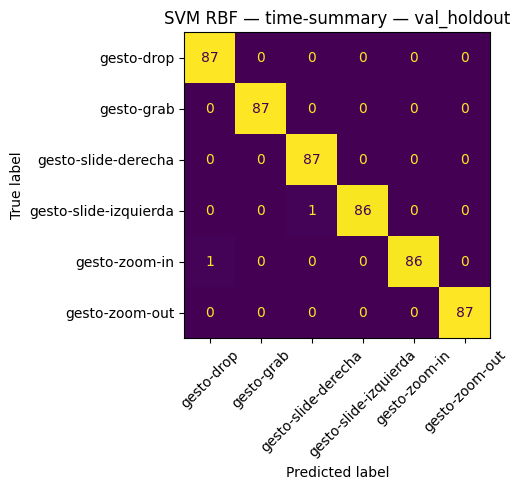


SVM RBF — Variante: time-extended


Grid SVM RBF (time-extended):   0%|          | 0/25 [00:00<?, ?it/s]


Top-5 combinaciones por Macro-F1 (CV):
   C gamma  cv_acc_mean  cv_acc_std  cv_f1_macro_mean  cv_f1_macro_std
 2.0 scale     0.998558    0.002885          0.998560         0.002880
 5.0 scale     0.998558    0.002885          0.998560         0.002880
10.0 scale     0.998558    0.002885          0.998560         0.002880
 1.0 scale     0.998077    0.002803          0.998077         0.002799
 0.5 scale     0.996636    0.003261          0.996634         0.003253

Mejores params [time-extended] -> C=2.0 | gamma=scale
CV Macro-F1=0.9986 ± 0.0029 | CV Acc=0.9986 ± 0.0029

[time-extended | RBF] Evaluación en val_holdout
  Accuracy:  0.9962
  Macro-F1:  0.9962
                       precision    recall  f1-score   support

           gesto-drop       0.98      1.00      0.99        87
           gesto-grab       1.00      1.00      1.00        87
  gesto-slide-derecha       1.00      1.00      1.00        87
gesto-slide-izquierda       1.00      1.00      1.00        87
        gesto-zoom-in

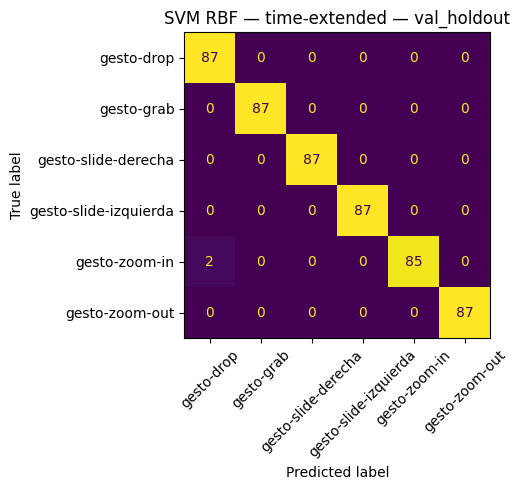


SVM RBF — Variante: time+fft


Grid SVM RBF (time+fft):   0%|          | 0/25 [00:00<?, ?it/s]


Top-5 combinaciones por Macro-F1 (CV):
   C gamma  cv_acc_mean  cv_acc_std  cv_f1_macro_mean  cv_f1_macro_std
 5.0 scale     0.992317    0.004130          0.992306         0.004142
10.0 scale     0.992317    0.004130          0.992306         0.004142
 2.0 scale     0.991836    0.003255          0.991826         0.003271
 1.0 scale     0.989914    0.002796          0.989901         0.002817
 0.5 scale     0.984150    0.006000          0.984197         0.005933

Mejores params [time+fft] -> C=5.0 | gamma=scale
CV Macro-F1=0.9923 ± 0.0041 | CV Acc=0.9923 ± 0.0041

[time+fft | RBF] Evaluación en val_holdout
  Accuracy:  0.9866
  Macro-F1:  0.9866
                       precision    recall  f1-score   support

           gesto-drop       0.98      0.95      0.97        87
           gesto-grab       1.00      0.98      0.99        87
  gesto-slide-derecha       0.97      1.00      0.98        87
gesto-slide-izquierda       1.00      1.00      1.00        87
        gesto-zoom-in       0.9

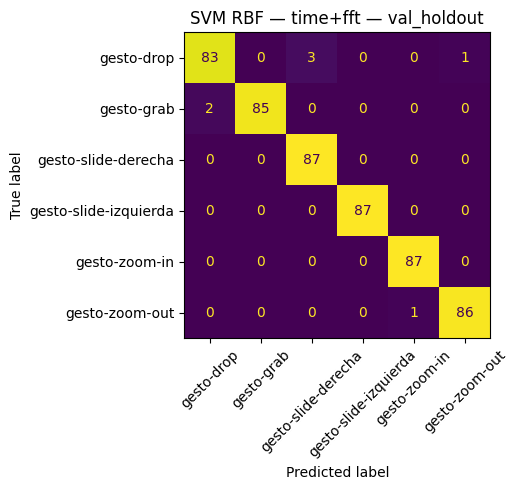


Resumen CV entre variantes (ordenado por Macro-F1):
      variant kernel  best_C best_gamma  cv_macroF1_mean  cv_macroF1_std  cv_acc_mean  cv_acc_std  holdout_acc  holdout_macroF1
time-extended    rbf     2.0      scale         0.998560        0.002880     0.998558    0.002885     0.996169         0.996168
 time-summary    rbf     0.5      scale         0.997612        0.003015     0.997600    0.003035     0.996169         0.996168
     time+fft    rbf     5.0      scale         0.992306        0.004142     0.992317    0.004130     0.986590         0.986555

Archivos guardados en: /content/gdrive_alt/MyDrive/Quiroscopio_DatasetBuild_v2


In [ ]:
# === 6B) SVM (RBF) con CV en core_pool + evaluación en val_holdout — CORREGIDO ===
from pathlib import Path
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from tqdm.auto import tqdm
from itertools import product

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import StratifiedKFold
from sklearn.svm import SVC
from sklearn.metrics import (
    accuracy_score, f1_score, classification_report,
    confusion_matrix, ConfusionMatrixDisplay
)

# ----------------------------
# Configuración por defecto (si no existen)
# ----------------------------
try:
    VARIANTS_TO_RUN
except NameError:
    VARIANTS_TO_RUN = ["time-summary", "time-extended", "time+fft"]

try:
    USE_PCA
except NameError:
    USE_PCA = {"time-summary": False, "time-extended": True, "time+fft": False}

try:
    PCA_DIMS
except NameError:
    PCA_DIMS = {"time-summary": 64, "time-extended": 128, "time+fft": 64}

CV_FOLDS = 5
RANDOM_STATE = 42

# Grilla de hiperparámetros (ajústala si necesitas más fino)
C_grid     = [0.5, 1, 2, 5, 10]
gamma_grid = ["scale", 0.01, 0.05, 0.1, 0.2]

# ----------------------------
# Utilidades
# ----------------------------
def load_features(variant: str, split: str):
    X = np.load(Path(OUT_DIR, f"{variant}_{split}.X.npy"))
    y = np.load(Path(OUT_DIR, f"{variant}_{split}.y.npy"))
    return X, y

def build_pipeline_rbf(variant: str) -> Pipeline:
    steps = [("scaler", StandardScaler())]
    if USE_PCA.get(variant, False):
        steps.append(("pca", PCA(n_components=PCA_DIMS.get(variant, 64), random_state=RANDOM_STATE)))
    steps.append(("svc", SVC(kernel="rbf", class_weight="balanced", probability=False, random_state=RANDOM_STATE)))
    return Pipeline(steps)

def _sanitize_rbf_params(pipe: Pipeline, params: dict) -> dict:
    """
    Acepta 'C'/'gamma' o 'svc__C'/'svc__gamma' y los mapea a los params del Pipeline.
    Ignora claves no válidas.
    """
    valid = pipe.get_params().keys()
    cleaned = {}
    for k, v in params.items():
        if k in ("C", "gamma"):
            k = f"svc__{k}"
        if k in valid:
            cleaned[k] = v
    return cleaned

def evaluate_holdout(best_params: dict, X_train, y_train, X_hold, y_hold, variant: str, title_suffix="val_holdout"):
    """
    Entrena SVM-RBF con los mejores hiperparámetros y evalúa en holdout.
    RETORNA: (acc, f1)
    """
    pipe = build_pipeline_rbf(variant)
    best_params = _sanitize_rbf_params(pipe, best_params)
    pipe.set_params(**best_params)
    pipe.fit(X_train, y_train)
    pred = pipe.predict(X_hold)

    acc = accuracy_score(y_hold, pred)
    f1  = f1_score(y_hold, pred, average="macro")

    print(f"\n[{variant} | RBF] Evaluación en {title_suffix}")
    print(f"  Accuracy:  {acc:.4f}")
    print(f"  Macro-F1:  {f1:.4f}")
    print(classification_report(y_hold, pred))

    cm = confusion_matrix(y_hold, pred, labels=np.unique(y_train))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y_train))
    fig, ax = plt.subplots(figsize=(6,5))
    disp.plot(ax=ax, xticks_rotation=45, colorbar=False)
    ax.set_title(f"SVM RBF — {variant} — {title_suffix}")
    plt.tight_layout()
    plt.show()

    return acc, f1

def grid_search_cv_svm_rbf(X, y, variant: str):
    cv = StratifiedKFold(n_splits=CV_FOLDS, shuffle=True, random_state=RANDOM_STATE)
    results = []
    combos = list(product(C_grid, gamma_grid))
    pbar = tqdm(combos, desc=f"Grid SVM RBF ({variant})", leave=False)
    for C, gamma in pbar:
        accs, f1s = [], []
        for tr, va in cv.split(X, y):
            pipe = build_pipeline_rbf(variant)
            pipe.set_params(svc__C=C, svc__gamma=gamma)
            pipe.fit(X[tr], y[tr])
            pred = pipe.predict(X[va])
            accs.append(accuracy_score(y[va], pred))
            f1s.append(f1_score(y[va], pred, average="macro"))
        row = {
            "C": C, "gamma": gamma,
            "cv_acc_mean": float(np.mean(accs)), "cv_acc_std": float(np.std(accs)),
            "cv_f1_macro_mean": float(np.mean(f1s)), "cv_f1_macro_std": float(np.std(f1s))
        }
        results.append(row)
        pbar.set_postfix(acc=f"{row['cv_acc_mean']:.3f}", f1=f"{row['cv_f1_macro_mean']:.3f}")
    df = pd.DataFrame(results).sort_values(["cv_f1_macro_mean","cv_acc_mean"], ascending=False).reset_index(drop=True)
    return df

# ----------------------------
# Ejecución por variante
# ----------------------------
summary_rows = []

for variant in VARIANTS_TO_RUN:
    print("\n" + "="*60)
    print(f"SVM RBF — Variante: {variant}")
    print("="*60)

    # Cargar datos
    X_core, y_core = load_features(variant, "core_pool")
    X_hold, y_hold = load_features(variant, "val_holdout")

    # GridSearch CV
    df_cv = grid_search_cv_svm_rbf(X_core, y_core, variant)
    print("\nTop-5 combinaciones por Macro-F1 (CV):")
    print(df_cv.head(5).to_string(index=False))

    # Mejores hiperparámetros (diccionario simple)
    best = df_cv.iloc[0].to_dict()
    print(f"\nMejores params [{variant}] -> C={best['C']} | gamma={best['gamma']}")
    print(f"CV Macro-F1={best['cv_f1_macro_mean']:.4f} ± {best['cv_f1_macro_std']:.4f} | "
          f"CV Acc={best['cv_acc_mean']:.4f} ± {best['cv_acc_std']:.4f}")

    # Evaluación externa en holdout (20%), retorna (acc, f1)
    acc_holdout, f1_holdout = evaluate_holdout(best, X_core, y_core, X_hold, y_hold, variant, title_suffix="val_holdout")

    # Acumular resumen (incluye holdout)
    summary_rows.append({
        "variant": variant,
        "kernel": "rbf",
        "best_C": best["C"],
        "best_gamma": best["gamma"],
        "cv_macroF1_mean": best["cv_f1_macro_mean"],
        "cv_macroF1_std": best["cv_f1_macro_std"],
        "cv_acc_mean": best["cv_acc_mean"],
        "cv_acc_std": best["cv_acc_std"],
        "holdout_acc": acc_holdout,
        "holdout_macroF1": f1_holdout
    })

# Resumen comparativo entre variantes
df_summary = pd.DataFrame(summary_rows).sort_values("cv_macroF1_mean", ascending=False)
print("\nResumen CV entre variantes (ordenado por Macro-F1):")
print(df_summary.to_string(index=False))

# Guardar
df_summary.to_csv(Path(OUT_DIR, "svm_cv_summary.csv"), index=False)
df_summary.to_parquet(Path(OUT_DIR, "svm_cv_summary.parquet"), index=False)
print("\nArchivos guardados en:", OUT_DIR)



SVM Lineal vs Polinomial — Variante: time-summary


Grid SVM Linear (time-summary):   0%|          | 0/5 [00:00<?, ?it/s]


Top-5 LINEAR (por Macro-F1, CV):
kernel  svc__C  cv_acc_mean  cv_acc_std  cv_f1_macro_mean  cv_f1_macro_std
linear     0.5          1.0         0.0               1.0              0.0
linear     1.0          1.0         0.0               1.0              0.0
linear     2.0          1.0         0.0               1.0              0.0
linear     5.0          1.0         0.0               1.0              0.0
linear    10.0          1.0         0.0               1.0              0.0

Mejor LINEAR -> svc__C=0.5
CV Macro-F1=1.0000 ± 0.0000 | CV Acc=1.0000 ± 0.0000

[time-summary | LINEAR] Evaluación en val_holdout
  Accuracy:  0.9981
  Macro-F1:  0.9981
                       precision    recall  f1-score   support

           gesto-drop       0.99      1.00      0.99        87
           gesto-grab       1.00      1.00      1.00        87
  gesto-slide-derecha       1.00      1.00      1.00        87
gesto-slide-izquierda       1.00      1.00      1.00        87
        gesto-zoom-in       

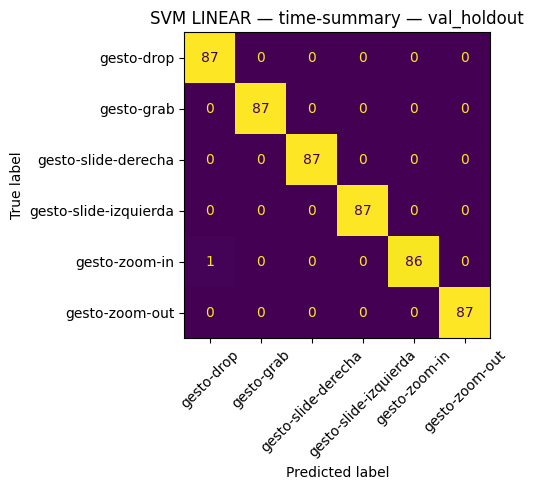

Grid SVM Poly (time-summary):   0%|          | 0/16 [00:00<?, ?it/s]


Top-5 POLY (por Macro-F1, CV):
kernel  svc__C  svc__degree svc__gamma  svc__coef0  cv_acc_mean  cv_acc_std  cv_f1_macro_mean  cv_f1_macro_std
  poly     0.5            2      scale         0.0     0.999519    0.000962          0.999517         0.000966
  poly     0.5            2      scale         0.5     0.999519    0.000962          0.999517         0.000966
  poly     0.5            3      scale         0.0     0.999519    0.000962          0.999517         0.000966
  poly     0.5            3      scale         0.5     0.999519    0.000962          0.999517         0.000966
  poly     1.0            2      scale         0.0     0.999519    0.000962          0.999517         0.000966

Mejor POLY -> svc__C=0.5, svc__degree=2, svc__gamma=scale, svc__coef0=0.0
CV Macro-F1=0.9995 ± 0.0010 | CV Acc=0.9995 ± 0.0010

[time-summary | POLY] Evaluación en val_holdout
  Accuracy:  0.9981
  Macro-F1:  0.9981
                       precision    recall  f1-score   support

           gesto-drop

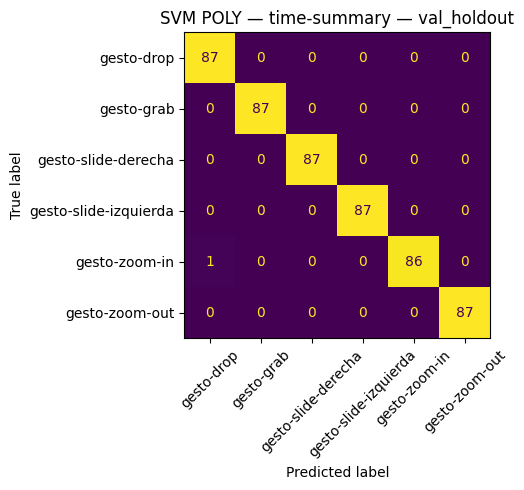


SVM Lineal vs Polinomial — Variante: time-extended


Grid SVM Linear (time-extended):   0%|          | 0/5 [00:00<?, ?it/s]


Top-5 LINEAR (por Macro-F1, CV):
kernel  svc__C  cv_acc_mean  cv_acc_std  cv_f1_macro_mean  cv_f1_macro_std
linear     0.5     0.998558    0.001923          0.998557         0.001921
linear     1.0     0.998558    0.001923          0.998557         0.001921
linear     2.0     0.998558    0.001923          0.998557         0.001921
linear     5.0     0.998558    0.001923          0.998557         0.001921
linear    10.0     0.998558    0.001923          0.998557         0.001921

Mejor LINEAR -> svc__C=0.5
CV Macro-F1=0.9986 ± 0.0019 | CV Acc=0.9986 ± 0.0019

[time-extended | LINEAR] Evaluación en val_holdout
  Accuracy:  0.9962
  Macro-F1:  0.9962
                       precision    recall  f1-score   support

           gesto-drop       0.98      1.00      0.99        87
           gesto-grab       1.00      1.00      1.00        87
  gesto-slide-derecha       1.00      1.00      1.00        87
gesto-slide-izquierda       1.00      1.00      1.00        87
        gesto-zoom-in      

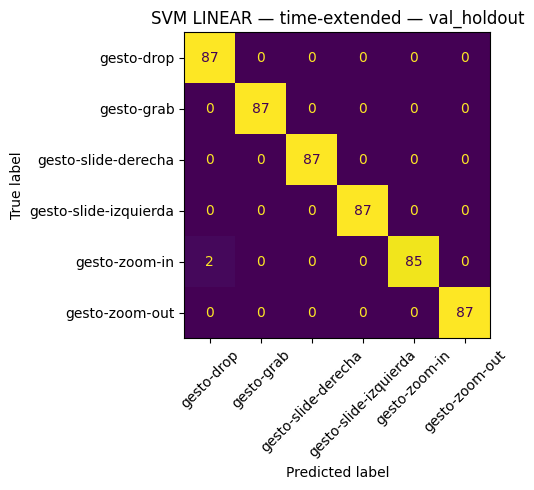

Grid SVM Poly (time-extended):   0%|          | 0/16 [00:00<?, ?it/s]


Top-5 POLY (por Macro-F1, CV):
kernel  svc__C  svc__degree svc__gamma  svc__coef0  cv_acc_mean  cv_acc_std  cv_f1_macro_mean  cv_f1_macro_std
  poly     1.0            3      scale         0.5          1.0         0.0               1.0              0.0
  poly     2.0            2      scale         0.5          1.0         0.0               1.0              0.0
  poly     2.0            3      scale         0.5          1.0         0.0               1.0              0.0
  poly     5.0            2      scale         0.5          1.0         0.0               1.0              0.0
  poly     5.0            3      scale         0.5          1.0         0.0               1.0              0.0

Mejor POLY -> svc__C=1.0, svc__degree=3, svc__gamma=scale, svc__coef0=0.5
CV Macro-F1=1.0000 ± 0.0000 | CV Acc=1.0000 ± 0.0000

[time-extended | POLY] Evaluación en val_holdout
  Accuracy:  0.9962
  Macro-F1:  0.9962
                       precision    recall  f1-score   support

           gesto-dro

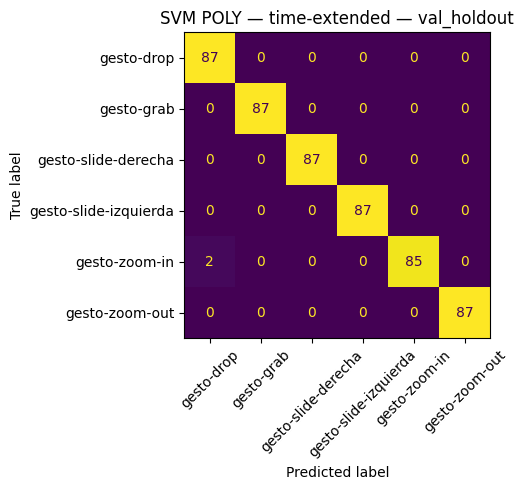


SVM Lineal vs Polinomial — Variante: time+fft


Grid SVM Linear (time+fft):   0%|          | 0/5 [00:00<?, ?it/s]


Top-5 LINEAR (por Macro-F1, CV):
kernel  svc__C  cv_acc_mean  cv_acc_std  cv_f1_macro_mean  cv_f1_macro_std
linear     0.5     0.993756    0.001178          0.993761         0.001171
linear     1.0     0.993756    0.001178          0.993761         0.001171
linear     2.0     0.993756    0.001178          0.993761         0.001171
linear     5.0     0.993756    0.001178          0.993761         0.001171
linear    10.0     0.993756    0.001178          0.993761         0.001171

Mejor LINEAR -> svc__C=0.5
CV Macro-F1=0.9938 ± 0.0012 | CV Acc=0.9938 ± 0.0012

[time+fft | LINEAR] Evaluación en val_holdout
  Accuracy:  0.9904
  Macro-F1:  0.9904
                       precision    recall  f1-score   support

           gesto-drop       0.99      1.00      0.99        87
           gesto-grab       1.00      0.99      0.99        87
  gesto-slide-derecha       1.00      0.97      0.98        87
gesto-slide-izquierda       0.97      1.00      0.98        87
        gesto-zoom-in       0.99

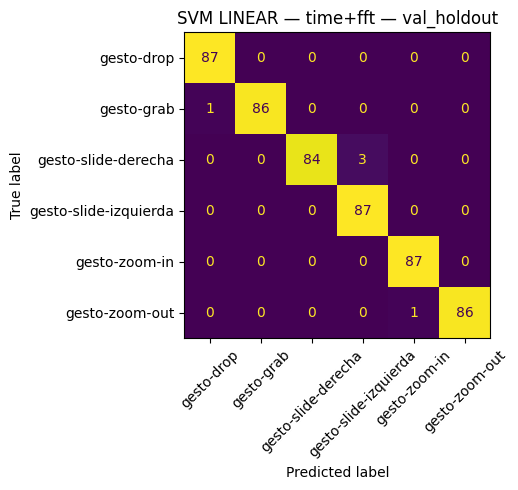

Grid SVM Poly (time+fft):   0%|          | 0/16 [00:00<?, ?it/s]


Top-5 POLY (por Macro-F1, CV):
kernel  svc__C  svc__degree svc__gamma  svc__coef0  cv_acc_mean  cv_acc_std  cv_f1_macro_mean  cv_f1_macro_std
  poly     1.0            2      scale         0.5     0.996158    0.001174          0.996163         0.001175
  poly     1.0            3      scale         0.5     0.995678    0.001798          0.995683         0.001795
  poly     2.0            3      scale         0.5     0.995678    0.001798          0.995683         0.001795
  poly     5.0            3      scale         0.5     0.995678    0.001798          0.995683         0.001795
  poly     5.0            2      scale         0.5     0.995679    0.001793          0.995679         0.001796

Mejor POLY -> svc__C=1.0, svc__degree=2, svc__gamma=scale, svc__coef0=0.5
CV Macro-F1=0.9962 ± 0.0012 | CV Acc=0.9962 ± 0.0012

[time+fft | POLY] Evaluación en val_holdout
  Accuracy:  0.9962
  Macro-F1:  0.9962
                       precision    recall  f1-score   support

           gesto-drop    

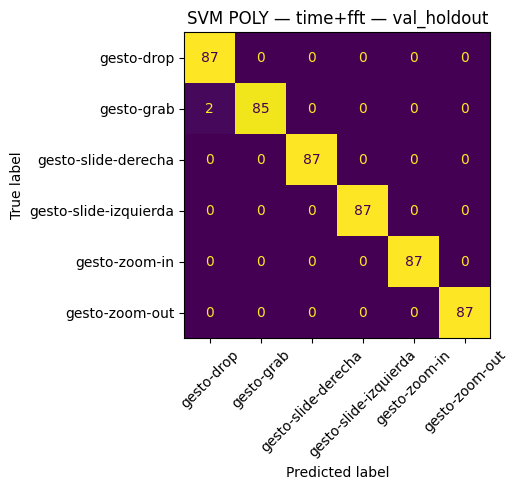


Resumen comparativo (LINEAR vs POLY por variante, ordenado por holdout Macro-F1):
      variant kernel                                                                 best_params  cv_macroF1_mean  cv_macroF1_std  cv_acc_mean  cv_acc_std  holdout_acc  holdout_macroF1
     time+fft   poly {'svc__C': 1.0, 'svc__degree': 2, 'svc__gamma': 'scale', 'svc__coef0': 0.5}         0.996163        0.001175     0.996158    0.001174     0.996169         0.996168
     time+fft linear                                                             {'svc__C': 0.5}         0.993761        0.001171     0.993756    0.001178     0.990421         0.990420
time-extended linear                                                             {'svc__C': 0.5}         0.998557        0.001921     0.998558    0.001923     0.996169         0.996168
time-extended   poly {'svc__C': 1.0, 'svc__degree': 3, 'svc__gamma': 'scale', 'svc__coef0': 0.5}         1.000000        0.000000     1.000000    0.000000     0.996169         0

In [ ]:
# === 6C) SVM Lineal y SVM Polinomial: CV en core_pool + evaluación en val_holdout (CORREGIDO) ===
from pathlib import Path
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from tqdm.auto import tqdm
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import StratifiedKFold
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

# --- Config por defecto si no existen en el entorno ---
try:
    VARIANTS_TO_RUN
except NameError:
    VARIANTS_TO_RUN = ["time-summary", "time-extended", "time+fft"]

try:
    USE_PCA
except NameError:
    USE_PCA = {"time-summary": False, "time-extended": True, "time+fft": False}

try:
    PCA_DIMS
except NameError:
    PCA_DIMS = {"time-summary": 64, "time-extended": 128, "time+fft": 64}

CV_FOLDS = 5
RANDOM_STATE = 42

# Grillas compactas
GRID_LINEAR = {
    "svc__C": [0.5, 1, 2, 5, 10]
}
GRID_POLY = {
    "svc__C": [0.5, 1, 2, 5],
    "svc__degree": [2, 3],
    "svc__gamma": ["scale"],     # puedes añadir 0.05, 0.1 si deseas
    "svc__coef0": [0.0, 0.5]
}

# --- Utilidades ---
def load_features(variant: str, split: str):
    X = np.load(Path(OUT_DIR, f"{variant}_{split}.X.npy"))
    y = np.load(Path(OUT_DIR, f"{variant}_{split}.y.npy"))
    return X, y

def build_pipeline(variant: str, kernel: str):
    steps = [("scaler", StandardScaler())]
    if USE_PCA.get(variant, False):
        steps.append(("pca", PCA(n_components=PCA_DIMS.get(variant, 64), random_state=RANDOM_STATE)))
    steps.append(("svc", SVC(kernel=kernel, class_weight="balanced", probability=False, random_state=RANDOM_STATE)))
    return Pipeline(steps)

def sanitize_params(pipe: Pipeline, params: dict):
    """
    Filtra/renombra params para que coincidan con el Pipeline:
    - Ignora 'kernel' (se fija al construir).
    - Acepta 'svc__*'.
    - Si llega sin prefijo (p.ej. 'C'), lo mapea a 'svc__C' si existe.
    """
    valid = pipe.get_params().keys()
    cleaned = {}
    for k, v in params.items():
        if k == "kernel":
            continue
        if k in valid:
            cleaned[k] = v
        elif f"svc__{k}" in valid:
            cleaned[f"svc__{k}"] = v
        # Si no existe en el Pipe, se ignora
    return cleaned

def cv_search(X, y, variant: str, kernel: str, param_grid: dict, desc: str):
    from itertools import product
    cv = StratifiedKFold(n_splits=CV_FOLDS, shuffle=True, random_state=RANDOM_STATE)
    keys = list(param_grid.keys())
    combos = [dict(zip(keys, vals)) for vals in product(*[param_grid[k] for k in keys])]
    results = []
    pbar = tqdm(combos, desc=f"{desc} ({variant})", leave=False)
    for params in pbar:
        accs, f1s = [], []
        for tr, va in cv.split(X, y):
            pipe = build_pipeline(variant, kernel)
            pipe.set_params(**params)
            pipe.fit(X[tr], y[tr])
            pred = pipe.predict(X[va])
            accs.append(accuracy_score(y[va], pred))
            f1s.append(f1_score(y[va], pred, average="macro"))
        row = {"kernel": kernel, **params,
               "cv_acc_mean": float(np.mean(accs)), "cv_acc_std": float(np.std(accs)),
               "cv_f1_macro_mean": float(np.mean(f1s)), "cv_f1_macro_std": float(np.std(f1s))}
        results.append(row)
        pbar.set_postfix(acc=f"{row['cv_acc_mean']:.3f}", f1=f"{row['cv_f1_macro_mean']:.3f}")
    df = pd.DataFrame(results).sort_values(["cv_f1_macro_mean","cv_acc_mean"], ascending=False).reset_index(drop=True)
    return df

def evaluate_holdout(best_params: dict, X_train, y_train, X_hold, y_hold, variant: str, kernel: str, title_suffix="val_holdout"):
    pipe = build_pipeline(variant, kernel)
    # Sanitizar (evita error por pasar 'kernel' u otros no válidos)
    best_params = sanitize_params(pipe, best_params)
    pipe.set_params(**best_params)
    pipe.fit(X_train, y_train)
    pred = pipe.predict(X_hold)
    acc = accuracy_score(y_hold, pred)
    f1  = f1_score(y_hold, pred, average="macro")
    print(f"\n[{variant} | {kernel.upper()}] Evaluación en {title_suffix}")
    print(f"  Accuracy:  {acc:.4f}")
    print(f"  Macro-F1:  {f1:.4f}")
    print(classification_report(y_hold, pred))
    cm = confusion_matrix(y_hold, pred, labels=np.unique(y_train))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y_train))
    fig, ax = plt.subplots(figsize=(6,5))
    disp.plot(ax=ax, xticks_rotation=45, colorbar=False)
    ax.set_title(f"SVM {kernel.upper()} — {variant} — {title_suffix}")
    plt.tight_layout()
    plt.show()
    return acc, f1

# --- Ejecución principal ---
summary_rows = []
for variant in VARIANTS_TO_RUN:
    print("\n" + "="*70)
    print(f"SVM Lineal vs Polinomial — Variante: {variant}")
    print("="*70)

    # Carga
    X_core, y_core = load_features(variant, "core_pool")
    X_hold, y_hold = load_features(variant, "val_holdout")

    # ===== LINEAL =====
    df_lin = cv_search(X_core, y_core, variant, kernel="linear", param_grid=GRID_LINEAR, desc="Grid SVM Linear")
    print("\nTop-5 LINEAR (por Macro-F1, CV):")
    print(df_lin.head(5).to_string(index=False))

    # Tomar SOLO hiperparámetros 'svc__*'
    best_lin_params = df_lin.iloc[0][[c for c in df_lin.columns if c.startswith("svc__")]].to_dict()
    print(f"\nMejor LINEAR -> " + ", ".join([f"{k}={v}" for k,v in best_lin_params.items()]))
    print(f"CV Macro-F1={df_lin.iloc[0]['cv_f1_macro_mean']:.4f} ± {df_lin.iloc[0]['cv_f1_macro_std']:.4f} | "
          f"CV Acc={df_lin.iloc[0]['cv_acc_mean']:.4f} ± {df_lin.iloc[0]['cv_acc_std']:.4f}")

    acc_lin, f1_lin = evaluate_holdout(best_lin_params, X_core, y_core, X_hold, y_hold, variant, kernel="linear")

    summary_rows.append({
        "variant": variant, "kernel": "linear",
        "best_params": best_lin_params,
        "cv_macroF1_mean": df_lin.iloc[0]["cv_f1_macro_mean"], "cv_macroF1_std": df_lin.iloc[0]["cv_f1_macro_std"],
        "cv_acc_mean": df_lin.iloc[0]["cv_acc_mean"], "cv_acc_std": df_lin.iloc[0]["cv_acc_std"],
        "holdout_acc": acc_lin, "holdout_macroF1": f1_lin
    })

    # ===== POLINOMIAL =====
    df_poly = cv_search(X_core, y_core, variant, kernel="poly", param_grid=GRID_POLY, desc="Grid SVM Poly")
    print("\nTop-5 POLY (por Macro-F1, CV):")
    print(df_poly.head(5).to_string(index=False))

    best_poly_params = df_poly.iloc[0][[c for c in df_poly.columns if c.startswith("svc__")]].to_dict()
    print(f"\nMejor POLY -> " + ", ".join([f"{k}={v}" for k,v in best_poly_params.items()]))
    print(f"CV Macro-F1={df_poly.iloc[0]['cv_f1_macro_mean']:.4f} ± {df_poly.iloc[0]['cv_f1_macro_std']:.4f} | "
          f"CV Acc={df_poly.iloc[0]['cv_acc_mean']:.4f} ± {df_poly.iloc[0]['cv_acc_std']:.4f}")

    acc_poly, f1_poly = evaluate_holdout(best_poly_params, X_core, y_core, X_hold, y_hold, variant, kernel="poly")

    summary_rows.append({
        "variant": variant, "kernel": "poly",
        "best_params": best_poly_params,
        "cv_macroF1_mean": df_poly.iloc[0]["cv_f1_macro_mean"], "cv_macroF1_std": df_poly.iloc[0]["cv_f1_macro_std"],
        "cv_acc_mean": df_poly.iloc[0]["cv_acc_mean"], "cv_acc_std": df_poly.iloc[0]["cv_acc_std"],
        "holdout_acc": acc_poly, "holdout_macroF1": f1_poly
    })

# Resumen comparativo
df_cmp = pd.DataFrame(summary_rows).sort_values(["variant","holdout_macroF1"], ascending=[True, False]).reset_index(drop=True)
print("\nResumen comparativo (LINEAR vs POLY por variante, ordenado por holdout Macro-F1):")
print(df_cmp.to_string(index=False))

# Guardar
df_cmp.to_csv(Path(OUT_DIR, "svm_linear_poly_summary.csv"), index=False)
df_cmp.to_parquet(Path(OUT_DIR, "svm_linear_poly_summary.parquet"), index=False)
print("Archivos guardados en:", OUT_DIR)


In [ ]:
# === 7) Reportes de splits ===
def write_report(name, indices):
    rows=[]
    for i in indices:
        rows.append({"split":name, "idx":int(i),
                     "gesture":records[i]["gesture"],
                     "session":records[i]["session"],
                     "file":records[i]["file"],
                     "score_to_seeds": float(scores_by_idx.get(int(i), np.nan))})
    df = pd.DataFrame(rows)
    base = Path(OUT_DIR, f"report_{name}")
    df.to_csv(base.with_suffix(".csv"), index=False)
    df.to_parquet(base.with_suffix(".parquet"), index=False)
    return df

df_core = write_report("core_pool", core_pool_idx)
df_hold = write_report("val_holdout", val_holdout_idx)

print("Conteos por gesto (core_pool):")
print(df_core["gesture"].value_counts().sort_index())
print("\nConteos por gesto (val_holdout):")
print(df_hold["gesture"].value_counts().sort_index())


Conteos por gesto (core_pool):
gesture
gesto-drop               347
gesto-grab               347
gesto-slide-derecha      347
gesto-slide-izquierda    347
gesto-zoom-in            347
gesto-zoom-out           347
Name: count, dtype: int64

Conteos por gesto (val_holdout):
gesture
gesto-drop               87
gesto-grab               87
gesto-slide-derecha      87
gesto-slide-izquierda    87
gesto-zoom-in            87
gesto-zoom-out           87
Name: count, dtype: int64



 COMPARATIVA GENERAL SVM (RBF, LINEAR, POLY)

      variant kernel  svc__C svc__gamma svc__degree svc__coef0  cv_acc_mean  cv_acc_std  cv_f1_macro_mean  cv_f1_macro_std  holdout_acc  holdout_macroF1
     time+fft   poly     NaN        NaN         NaN        NaN     0.996158    0.001174               NaN              NaN     0.996169         0.996168
     time+fft linear     NaN        NaN         NaN        NaN     0.993756    0.001178               NaN              NaN     0.990421         0.990420
     time+fft    rbf     5.0      scale        None       None     0.992317    0.004130          0.992306         0.004142     0.986590         0.986555
time-extended    rbf     2.0      scale        None       None     0.998558    0.002885          0.998560         0.002880     0.996169         0.996168
time-extended linear     NaN        NaN         NaN        NaN     0.998558    0.001923               NaN              NaN     0.996169         0.996168
time-extended   poly     NaN       

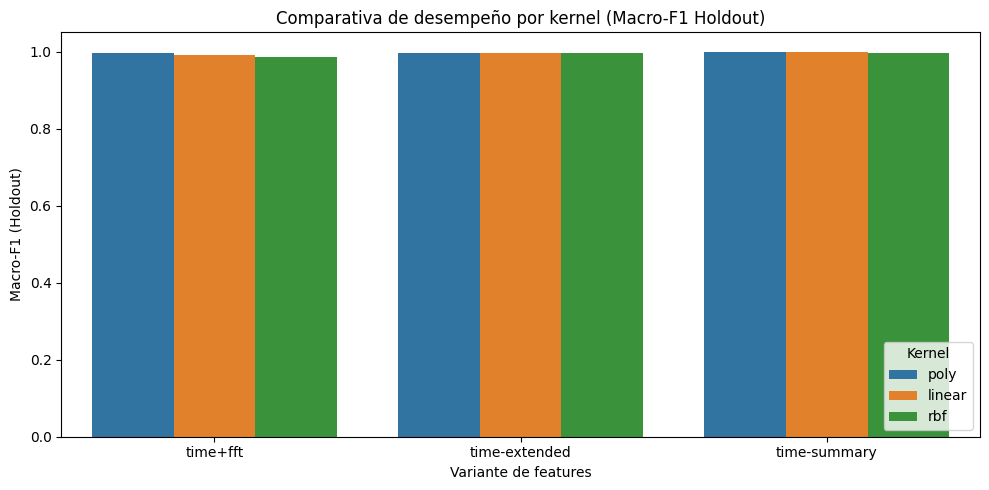

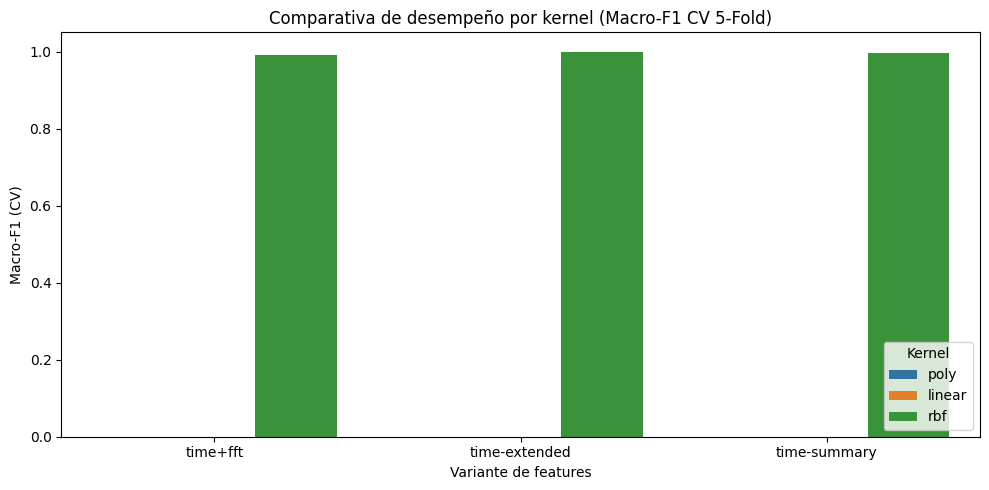


Archivos exportados:
 - /content/gdrive_alt/MyDrive/Quiroscopio_DatasetBuild_v2/svm_comparativa_general.csv
 - /content/gdrive_alt/MyDrive/Quiroscopio_DatasetBuild_v2/svm_comparativa_general.parquet


In [ ]:
# === 7) Comparativa general entre SVM-RBF, SVM-Lineal y SVM-Polinomial ===
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# ----------------------------
# Cargar resúmenes previos
# ----------------------------
path_rbf = Path(OUT_DIR, "svm_cv_summary.csv")               # generado en bloque 6B
path_linpoly = Path(OUT_DIR, "svm_linear_poly_summary.csv")  # generado en bloque 6C

df_rbf = pd.read_csv(path_rbf) if path_rbf.exists() else pd.DataFrame()
df_linpoly = pd.read_csv(path_linpoly) if path_linpoly.exists() else pd.DataFrame()

# Normalizar columnas para que coincidan
# (df_rbf tiene solo RBF, df_linpoly tiene LINEAL y POLY)
df_rbf["kernel"] = "rbf"
df_rbf.rename(columns={
    "best_C": "svc__C",
    "best_gamma": "svc__gamma",
    "cv_macroF1_mean": "cv_f1_macro_mean",
    "cv_macroF1_std": "cv_f1_macro_std",
    "cv_acc_mean": "cv_acc_mean",
    "cv_acc_std": "cv_acc_std"
}, inplace=True)

# Algunas columnas pueden faltar, agregarlas vacías para concatenar sin error
for col in ["svc__degree", "svc__coef0", "holdout_acc", "holdout_macroF1"]:
    if col not in df_rbf.columns:
        df_rbf[col] = None

# Unir
df_all = pd.concat([df_rbf, df_linpoly], ignore_index=True, sort=False)

# Ordenar columnas y limpiar
cols = ["variant", "kernel",
        "svc__C", "svc__gamma", "svc__degree", "svc__coef0",
        "cv_acc_mean", "cv_acc_std",
        "cv_f1_macro_mean", "cv_f1_macro_std",
        "holdout_acc", "holdout_macroF1"]
df_all = df_all[cols]

# Ordenar por variante y Macro-F1 (holdout)
df_all = df_all.sort_values(["variant", "holdout_macroF1"], ascending=[True, False]).reset_index(drop=True)

# ----------------------------
# Mostrar resumen general
# ----------------------------
print("\n===============================")
print(" COMPARATIVA GENERAL SVM (RBF, LINEAR, POLY)")
print("===============================\n")
print(df_all.to_string(index=False))

# ----------------------------
# Gráficas comparativas
# ----------------------------
plt.figure(figsize=(10,5))
sns.barplot(data=df_all, x="variant", y="holdout_macroF1", hue="kernel")
plt.title("Comparativa de desempeño por kernel (Macro-F1 Holdout)")
plt.ylabel("Macro-F1 (Holdout)")
plt.xlabel("Variante de features")
plt.ylim(0,1.05)
plt.legend(title="Kernel", loc="lower right")
plt.tight_layout()
plt.show()

plt.figure(figsize=(10,5))
sns.barplot(data=df_all, x="variant", y="cv_f1_macro_mean", hue="kernel")
plt.title("Comparativa de desempeño por kernel (Macro-F1 CV 5-Fold)")
plt.ylabel("Macro-F1 (CV)")
plt.xlabel("Variante de features")
plt.ylim(0,1.05)
plt.legend(title="Kernel", loc="lower right")
plt.tight_layout()
plt.show()

# ----------------------------
# Guardar resultados
# ----------------------------
out_csv = Path(OUT_DIR, "svm_comparativa_general.csv")
out_parq = Path(OUT_DIR, "svm_comparativa_general.parquet")
df_all.to_csv(out_csv, index=False)
df_all.to_parquet(out_parq, index=False)

print("\nArchivos exportados:")
print(" -", out_csv)
print(" -", out_parq)



 COMPARATIVA GENERAL SVM (RBF, LINEAR, POLY) — Corregida

      variant kernel  svc__C svc__gamma svc__degree svc__coef0  cv_acc_mean  cv_acc_std  cv_f1_macro_mean  cv_f1_macro_std  holdout_acc  holdout_macroF1
     time+fft   poly     NaN        NaN         NaN        NaN     0.996158    0.001174          0.996163         0.001175     0.996169         0.996168
     time+fft linear     NaN        NaN         NaN        NaN     0.993756    0.001178          0.993761         0.001171     0.990421         0.990420
     time+fft    rbf     5.0      scale        None       None     0.992317    0.004130          0.992306         0.004142     0.986590         0.986555
time-extended    rbf     2.0      scale        None       None     0.998558    0.002885          0.998560         0.002880     0.996169         0.996168
time-extended linear     NaN        NaN         NaN        NaN     0.998558    0.001923          0.998557         0.001921     0.996169         0.996168
time-extended   poly   

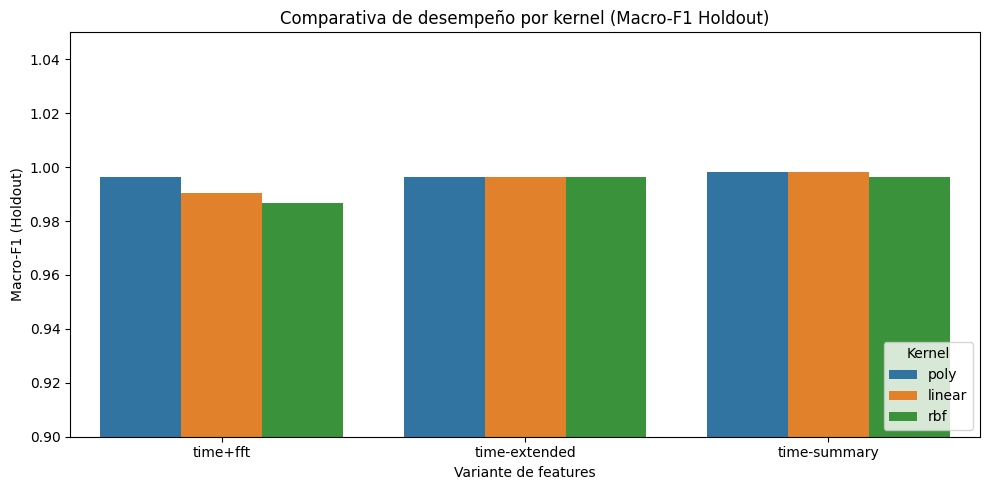

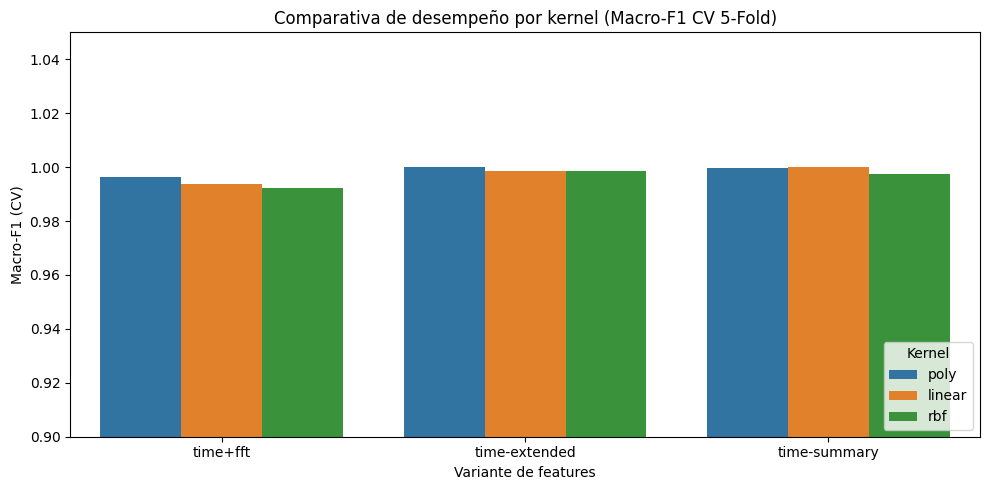


Archivos exportados:
 - /content/gdrive_alt/MyDrive/Quiroscopio_DatasetBuild_v2/svm_comparativa_general_corregida.csv
 - /content/gdrive_alt/MyDrive/Quiroscopio_DatasetBuild_v2/svm_comparativa_general_corregida.parquet


In [ ]:
# === 7) Comparativa general SVM (RBF, LINEAR, POLY) — Versión corregida ===
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

path_rbf = Path(OUT_DIR, "svm_cv_summary.csv")
path_linpoly = Path(OUT_DIR, "svm_linear_poly_summary.csv")

df_rbf = pd.read_csv(path_rbf) if path_rbf.exists() else pd.DataFrame()
df_linpoly = pd.read_csv(path_linpoly) if path_linpoly.exists() else pd.DataFrame()

# Normalizar columnas RBF
if not df_rbf.empty:
    df_rbf["kernel"] = "rbf"
    df_rbf.rename(columns={
        "best_C": "svc__C",
        "best_gamma": "svc__gamma",
        "cv_macroF1_mean": "cv_f1_macro_mean",
        "cv_macroF1_std": "cv_f1_macro_std",
        "cv_acc_mean": "cv_acc_mean",
        "cv_acc_std": "cv_acc_std",
        "holdout_acc": "holdout_acc",
        "holdout_macroF1": "holdout_macroF1"
    }, inplace=True)

# Asegurar columnas iguales
for col in ["svc__degree", "svc__coef0", "holdout_acc", "holdout_macroF1"]:
    if col not in df_rbf.columns:
        df_rbf[col] = None

# Uniformar lin/poly
if not df_linpoly.empty:
    df_linpoly.rename(columns={
        "cv_macroF1_mean": "cv_f1_macro_mean",
        "cv_macroF1_std": "cv_f1_macro_std"
    }, inplace=True)

# Concatenar
df_all = pd.concat([df_rbf, df_linpoly], ignore_index=True, sort=False)

# Seleccionar columnas en orden
cols = [
    "variant", "kernel",
    "svc__C", "svc__gamma", "svc__degree", "svc__coef0",
    "cv_acc_mean", "cv_acc_std", "cv_f1_macro_mean", "cv_f1_macro_std",
    "holdout_acc", "holdout_macroF1"
]
df_all = df_all[cols]

# Quitar filas vacías y ordenar
df_all = df_all.dropna(subset=["variant","kernel"]).sort_values(["variant","holdout_macroF1"], ascending=[True, False]).reset_index(drop=True)

print("\n===============================")
print(" COMPARATIVA GENERAL SVM (RBF, LINEAR, POLY) — Corregida")
print("===============================\n")
print(df_all.to_string(index=False))

# === Gráficas comparativas ===
plt.figure(figsize=(10,5))
sns.barplot(data=df_all, x="variant", y="holdout_macroF1", hue="kernel")
plt.title("Comparativa de desempeño por kernel (Macro-F1 Holdout)")
plt.ylabel("Macro-F1 (Holdout)")
plt.xlabel("Variante de features")
plt.ylim(0.9,1.05)
plt.legend(title="Kernel", loc="lower right")
plt.tight_layout()
plt.show()

plt.figure(figsize=(10,5))
sns.barplot(data=df_all, x="variant", y="cv_f1_macro_mean", hue="kernel")
plt.title("Comparativa de desempeño por kernel (Macro-F1 CV 5-Fold)")
plt.ylabel("Macro-F1 (CV)")
plt.xlabel("Variante de features")
plt.ylim(0.9,1.05)
plt.legend(title="Kernel", loc="lower right")
plt.tight_layout()
plt.show()

# Guardar resultados consolidados
out_csv = Path(OUT_DIR, "svm_comparativa_general_corregida.csv")
out_parq = Path(OUT_DIR, "svm_comparativa_general_corregida.parquet")
df_all.to_csv(out_csv, index=False)
df_all.to_parquet(out_parq, index=False)

print("\nArchivos exportados:")
print(" -", out_csv)
print(" -", out_parq)


/tmp/ipython-input-2563186080.py:27: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_all_knn = pd.concat([df_all, df_knn], ignore_index=True)



 COMPARATIVA GENERAL — SVM + KNN

      variant kernel  svc__C svc__gamma svc__degree svc__coef0  cv_acc_mean  cv_acc_std  cv_f1_macro_mean  cv_f1_macro_std  holdout_acc  holdout_macroF1
     time+fft   poly     NaN        NaN         NaN        NaN     0.996158    0.001174          0.996163         0.001175     0.996169         0.996168
     time+fft linear     NaN        NaN         NaN        NaN     0.993756    0.001178          0.993761         0.001171     0.990421         0.990420
     time+fft    rbf     5.0      scale        None       None     0.992317    0.004130          0.992306         0.004142          NaN              NaN
time-extended linear     NaN        NaN         NaN        NaN     0.998558    0.001923          0.998557         0.001921     0.996169         0.996168
time-extended   poly     NaN        NaN         NaN        NaN     1.000000    0.000000          1.000000         0.000000     0.996169         0.996168
time-extended    rbf     2.0      scale        

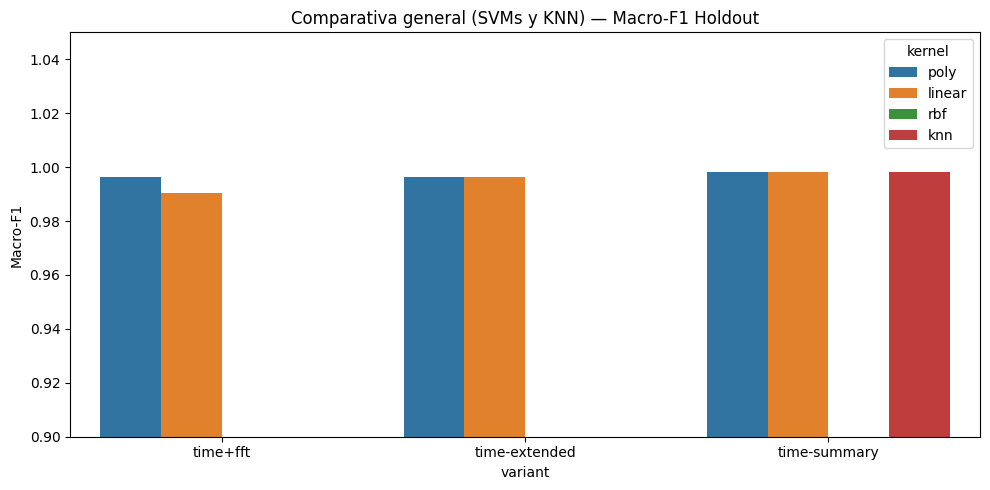

In [ ]:
# === 8) Agregar KNN a la comparativa general ===
import numpy as np
import pandas as pd

# Métricas de KNN (ya calculadas en bloque 6 anterior)
# Si las guardaste, puedes cargarlas; si no, las añadimos manualmente:
knn_results = {
    "time-summary": {"cv_macroF1_mean": np.mean(f1s), "cv_macroF1_std": np.std(f1s),
                     "holdout_acc": accuracy_score(ys_val, pred_val),
                     "holdout_macroF1": f1_score(ys_val, pred_val, average="macro")}
}

rows_knn = []
for variant, vals in knn_results.items():
    rows_knn.append({
        "variant": variant,
        "kernel": "knn",
        "svc__C": None, "svc__gamma": None, "svc__degree": None, "svc__coef0": None,
        "cv_acc_mean": None, "cv_acc_std": None,
        "cv_f1_macro_mean": vals["cv_macroF1_mean"], "cv_f1_macro_std": vals["cv_macroF1_std"],
        "holdout_acc": vals["holdout_acc"], "holdout_macroF1": vals["holdout_macroF1"]
    })

df_knn = pd.DataFrame(rows_knn)

# Combinar con comparativa SVM existente
df_all_knn = pd.concat([df_all, df_knn], ignore_index=True)

# Ordenar y mostrar
df_all_knn = df_all_knn.sort_values(["variant","holdout_macroF1"], ascending=[True, False])
print("\n===============================")
print(" COMPARATIVA GENERAL — SVM + KNN")
print("===============================\n")
print(df_all_knn.to_string(index=False))

# Graficar
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(10,5))
sns.barplot(data=df_all_knn, x="variant", y="holdout_macroF1", hue="kernel")
plt.title("Comparativa general (SVMs y KNN) — Macro-F1 Holdout")
plt.ylabel("Macro-F1")
plt.ylim(0.9,1.05)
plt.tight_layout()
plt.show()


[OK] Cargando SVM-RBF: svm_cv_summary.csv
[OK] Cargando SVM Linear/Poly: svm_linear_poly_summary.csv
[AVISO] No se encontró KNN (opcional): knn_summary.csv (se omitirá)

 COMPARATIVA GENERAL (SVM RBF / LINEAR / POLY)

      variant kernel  svc__C svc__gamma  svc__degree  svc__coef0  cv_acc_mean  cv_acc_std  cv_f1_macro_mean  cv_f1_macro_std  holdout_acc  holdout_macroF1
     time+fft   poly     NaN        NaN          NaN         NaN     0.996158    0.001174          0.996163         0.001175     0.996169         0.996168
     time+fft linear     NaN        NaN          NaN         NaN     0.993756    0.001178          0.993761         0.001171     0.990421         0.990420
     time+fft    rbf     5.0      scale          NaN         NaN     0.992317    0.004130          0.992306         0.004142     0.986590         0.986555
time-extended    rbf     2.0      scale          NaN         NaN     0.998558    0.002885          0.998560         0.002880     0.996169         0.996168
time-ex

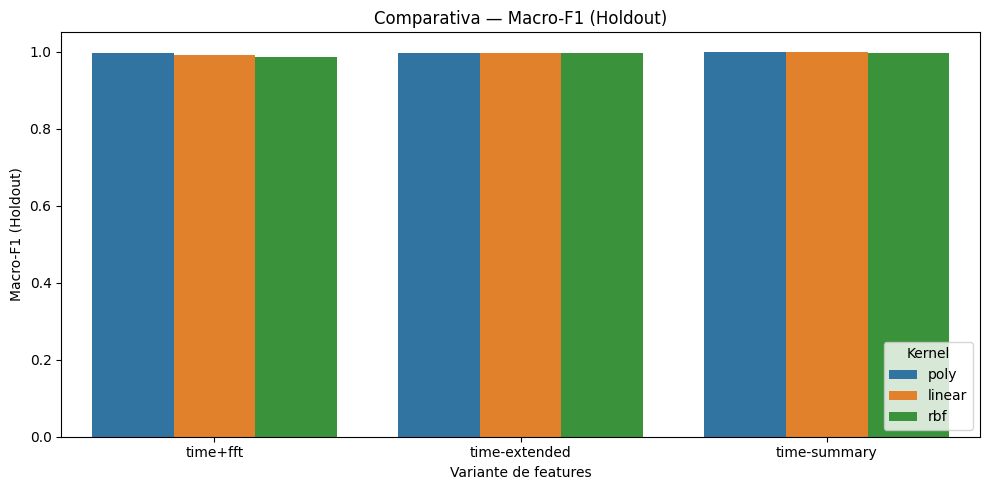

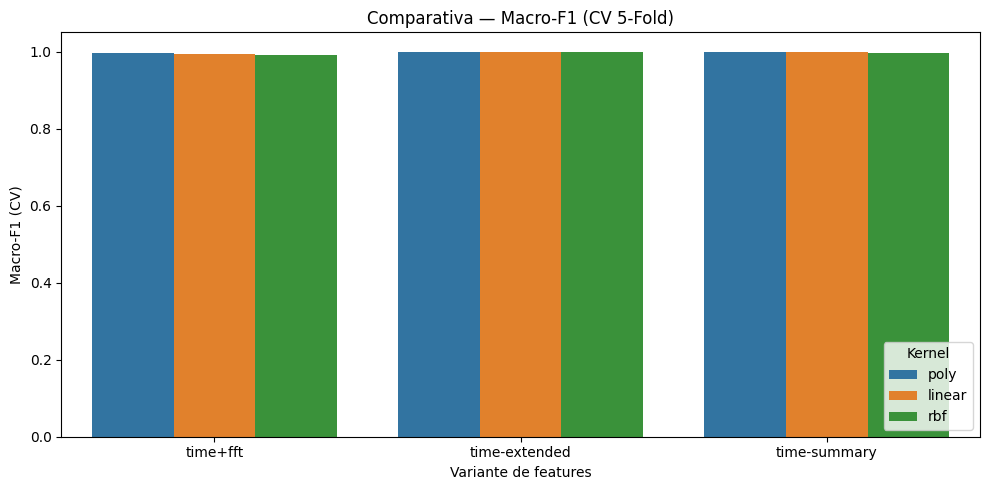


Archivos exportados:
 - /content/gdrive_alt/MyDrive/Quiroscopio_DatasetBuild_v2/comparativa_general.csv
 - /content/gdrive_alt/MyDrive/Quiroscopio_DatasetBuild_v2/comparativa_general.parquet


In [ ]:
# === 7) Comparativa general — SVM (RBF, LINEAR, POLY) [+ KNN opcional] ===
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# ---------- Archivos esperados ----------
path_rbf      = Path(OUT_DIR, "svm_cv_summary.csv")               # generado por 6B corregido
path_linpoly  = Path(OUT_DIR, "svm_linear_poly_summary.csv")      # generado por 6C
path_knn_opt  = Path(OUT_DIR, "knn_summary.csv")                  # opcional (si lo guardaste)

def load_csv_safe(path: Path, label: str) -> pd.DataFrame:
    if path.exists():
        print(f"[OK] Cargando {label}: {path.name}")
        return pd.read_csv(path)
    else:
        print(f"[AVISO] No se encontró {label}: {path.name} (se omitirá)")
        return pd.DataFrame()

df_rbf = load_csv_safe(path_rbf, "SVM-RBF")
df_lp  = load_csv_safe(path_linpoly, "SVM Linear/Poly")
df_knn = load_csv_safe(path_knn_opt, "KNN (opcional)")

# ---------- Normalización de columnas ----------
# RBF: asegurar nombres consistentes
if not df_rbf.empty:
    df_rbf["kernel"] = "rbf"
    df_rbf.rename(columns={
        "best_C": "svc__C",
        "best_gamma": "svc__gamma",
        "cv_macroF1_mean": "cv_f1_macro_mean",
        "cv_macroF1_std": "cv_f1_macro_std",
        "cv_acc_mean": "cv_acc_mean",
        "cv_acc_std": "cv_acc_std",
        # holdout_* ya vienen en 6B corregido
    }, inplace=True)
    # columnas que podrían no existir
    for col in ["svc__degree", "svc__coef0", "holdout_acc", "holdout_macroF1"]:
        if col not in df_rbf.columns:
            df_rbf[col] = np.nan

# Linear/Poly: ya incluyen holdout_*; renombrar métricas CV para unificación
if not df_lp.empty:
    df_lp.rename(columns={
        "cv_macroF1_mean": "cv_f1_macro_mean",
        "cv_macroF1_std": "cv_f1_macro_std"
    }, inplace=True)

# KNN opcional: espera columnas ["variant","cv_f1_macro_mean","cv_f1_macro_std","holdout_acc","holdout_macroF1"]
if not df_knn.empty:
    # Completar columnas faltantes para encajar con SVM
    for col in ["kernel","svc__C","svc__gamma","svc__degree","svc__coef0","cv_acc_mean","cv_acc_std"]:
        if col not in df_knn.columns:
            df_knn[col] = np.nan
    # Etiquetar kernel como 'knn'
    df_knn["kernel"] = "knn"

# ---------- Unificación ----------
frames = []
if not df_rbf.empty: frames.append(df_rbf)
if not df_lp.empty:  frames.append(df_lp)
if not df_knn.empty: frames.append(df_knn)

if not frames:
    raise RuntimeError("No hay resúmenes disponibles para comparar. Genera primero 6B y 6C (y KNN opcional).")

df_all = pd.concat(frames, ignore_index=True, sort=False)

# Selección y orden de columnas
cols = [
    "variant","kernel",
    "svc__C","svc__gamma","svc__degree","svc__coef0",
    "cv_acc_mean","cv_acc_std","cv_f1_macro_mean","cv_f1_macro_std",
    "holdout_acc","holdout_macroF1"
]
for c in cols:
    if c not in df_all.columns:
        df_all[c] = np.nan
df_all = df_all[cols]

# Ordenar por variante y desempeño en holdout
df_all_sorted = df_all.sort_values(["variant","holdout_macroF1"], ascending=[True, False]).reset_index(drop=True)

print("\n===============================")
print(" COMPARATIVA GENERAL (SVM RBF / LINEAR / POLY" + (" / KNN" if not df_knn.empty else "") + ")")
print("===============================\n")
print(df_all_sorted.to_string(index=False))

# ---------- Top-1 por variante (mejor holdout) ----------
print("\nTop-1 por variante (según Macro-F1 en Holdout):")
top1 = df_all_sorted.sort_values(["variant","holdout_macroF1"], ascending=[True, False]).groupby("variant").head(1)
print(top1[["variant","kernel","holdout_macroF1","cv_f1_macro_mean"]].to_string(index=False))

# ---------- Gráficas ----------
plt.figure(figsize=(10,5))
sns.barplot(data=df_all_sorted, x="variant", y="holdout_macroF1", hue="kernel")
plt.title("Comparativa — Macro-F1 (Holdout)")
plt.ylabel("Macro-F1 (Holdout)")
plt.xlabel("Variante de features")
plt.ylim(0.0, 1.05)
plt.legend(title="Kernel", loc="lower right")
plt.tight_layout()
plt.show()

plt.figure(figsize=(10,5))
sns.barplot(data=df_all_sorted, x="variant", y="cv_f1_macro_mean", hue="kernel")
plt.title("Comparativa — Macro-F1 (CV 5-Fold)")
plt.ylabel("Macro-F1 (CV)")
plt.xlabel("Variante de features")
plt.ylim(0.0, 1.05)
plt.legend(title="Kernel", loc="lower right")
plt.tight_layout()
plt.show()

# ---------- Guardar comparativa ----------
out_csv  = Path(OUT_DIR, "comparativa_general.csv")
out_parq = Path(OUT_DIR, "comparativa_general.parquet")
df_all_sorted.to_csv(out_csv, index=False)
df_all_sorted.to_parquet(out_parq, index=False)
print("\nArchivos exportados:")
print(" -", out_csv)
print(" -", out_parq)
